In [1]:
!pip install wordcloud

In [2]:
import io
import random
import string
import warnings
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import warnings
warnings.filterwarnings('ignore')

import nltk
from nltk.tokenize import sent_tokenize
from nltk.corpus import words
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *

 
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics


 
import re
import json
import os
from collections import Counter
import datetime as dt


 
from matplotlib import pyplot as plt
from matplotlib import ticker
import seaborn as sns
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from wordcloud import WordCloud
from tqdm import tqdm_notebook


 
import pickle

In [3]:
import sys
print(sys.executable)

C:\anaconda3\envs\gnn_inter\python.exe


In [4]:
data_dir = 'kaggle-covid-en-tweets-april_classified_claws.tar\kaggle-covid-en-tweets-april_classified_claws'
tweets = []
for file in sorted(os.listdir(data_dir)):
    tweets.append(pd.read_csv(data_dir + '/' + file, lineterminator = '\n'))

df = pd.concat(tweets)
df.tail()

,status_id,user_id,created_at,screen_name,text,source,reply_to_status_id,reply_to_user_id,reply_to_screen_name,is_quote,...,followers_count,friends_count,account_lang,account_created_at,verified,lang,Hate Probability,Counterhate Probability,Neutral Probability,Label
233370,1256010435641462784,7117302,2020-04-30T23:59:58Z,ozsultan,"Dear @NYCMayor,\n\nThe city has Millions to sp...",Twitter for iPhone,NaN,NaN,NaN,False,...,8723,7747,NaN,2007-06-27T20:09:29Z,False,en,0.000355,0.019420,0.974462,Neutral
233371,1256010442876608512,912319950559354880,2020-04-30T23:59:59Z,DriveLockGlobal,In the middle of the #COVID19 sales surge in M...,HubSpot,NaN,NaN,NaN,False,...,365,1333,NaN,2017-09-25T14:16:41Z,False,en,0.000800,0.005312,0.997671,Neutral
233372,1256010442696245253,18198832,2020-04-30T23:59:59Z,TheScientistLLC,"While the lockdown for #COVID19 continues on, ...",HubSpot,NaN,NaN,NaN,False,...,66844,383,NaN,2008-12-17T20:32:46Z,True,en,0.021656,0.000021,0.999820,Neutral
233373,1256010440154513408,937899468585828352,2020-04-30T23:59:59Z,portarican_RT,Best answer. #COVID19 #WeMournThemAll https://...,Twitter Web App,NaN,NaN,NaN,True,...,5503,5909,NaN,2017-12-05T04:20:33Z,False,en,0.015823,0.099499,0.656869,Neutral
233374,1256010440007716867,1043656483,2020-04-30T23:59:59Z,Drz123Z,@WFXTMalini @CMichaelGibson @boston25 I had th...,Twitter for iPhone,1.255987e+18,62144220.0,WFXTMalini,False,...,85,127,NaN,2012-12-29T02:35:23Z,False,en,0.056144,0.021127,0.873332,Neutral


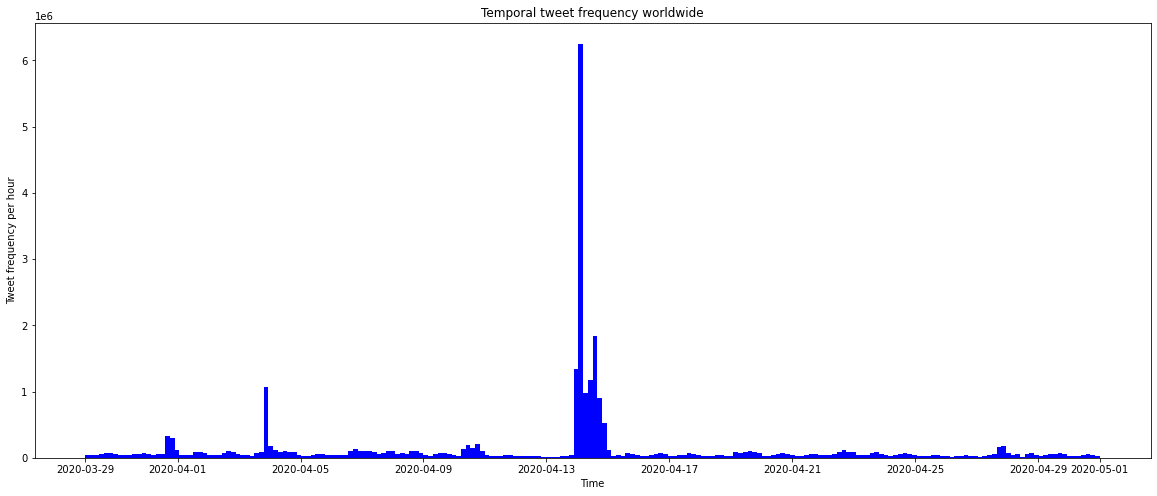

In [5]:
fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(111)
ax.set(title='Temporal tweet frequency worldwide', xlabel='Time', ylabel='Tweet frequency per hour')
plt.hist(pd.to_datetime(df.created_at), bins = 24*9, color = 'b')
plt.show()

In [7]:
text_en = df['text']
text_en_lr = text_en.apply(lambda x: re.sub(r"https\S+", "", str(x)))
text_en_lr.head()

0    “People are just storing up. They are staying ...
1    .@PatriceHarrisMD spoke with @YahooFinance abo...
2    First medical team aiding #Wuhan in fight agai...
3    .@KathyGriffin: @realDonaldTrump Is 'Lying' Ab...
4    #CoronaUpdate | Johns Hopkins University has s...
Name: text, dtype: object

In [13]:
text_en_lr_lc = text_en_lr.apply(lambda x: x.lower())
text_en_lr_lc.head()

0    “people are just storing up. they are staying ...
1    .@patriceharrismd spoke with @yahoofinance abo...
2    first medical team aiding #wuhan in fight agai...
3    .@kathygriffin: @realdonaldtrump is 'lying' ab...
4    #coronaupdate | johns hopkins university has s...
Name: text, dtype: object

In [9]:
text_en_lr_lc_pr = text_en_lr_lc.apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
text_en_lr_lc_pr.head()

0    “people are just storing up they are staying a...
1    patriceharrismd spoke with yahoofinance about ...
2    first medical team aiding wuhan in fight again...
3    kathygriffin realdonaldtrump is lying about co...
4    coronaupdate  johns hopkins university has sai...
Name: text, dtype: object

In [11]:
stop_words = set(stopwords.words('english'))
stop_words.update(['#coronavirus', '#coronavirusoutbreak', '#coronavirusPandemic', '#covid19', '#covid_19', '#epitwitter', '#ihavecorona', 'amp', 'coronavirus', 'covid19'])

text_en_lr_lc_pr_sr = text_en_lr_lc_pr.apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))
text_en_lr_lc_pr_sr.head()

0    “people storing staying home freezing things t...
1    patriceharrismd spoke yahoofinance stimulus pa...
2    first medical team aiding wuhan fight epidemic...
3      kathygriffin realdonaldtrump lying testing lgbt
4    coronaupdate johns hopkins university said aut...
Name: text, dtype: object

In [14]:
word_list = [word for line in text_en_lr_lc_pr_sr for word in line.split()]
word_list[:5]

['“people', 'storing', 'staying', 'home', 'freezing']

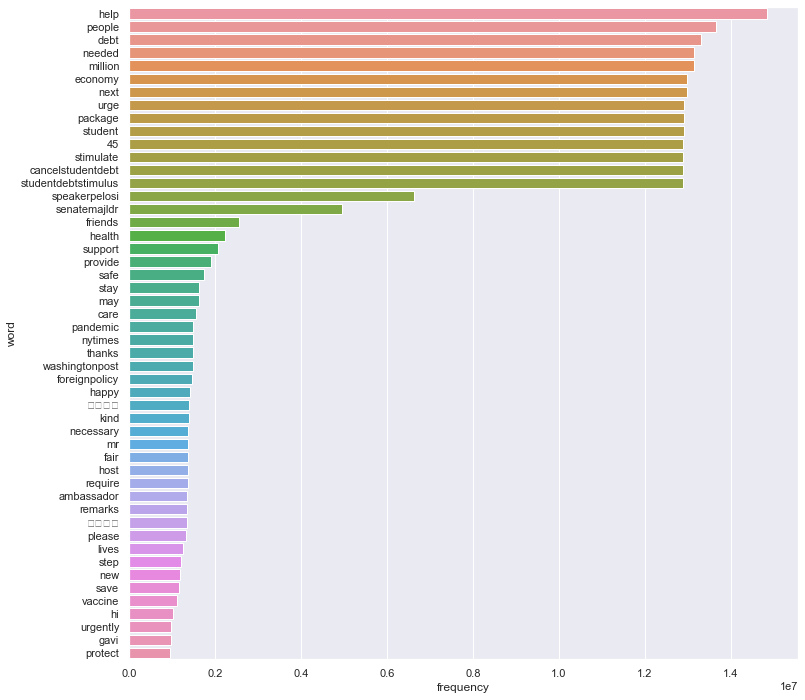

In [15]:
sns.set(style="darkgrid")
counts = Counter(word_list).most_common(50)
counts_df = pd.DataFrame(counts)
counts_df
counts_df.columns = ['word', 'frequency']

fig, ax = plt.subplots(figsize = (12, 12))
ax = sns.barplot(y="word", x='frequency', ax = ax, data=counts_df)
plt.savefig('wordcount_bar.png')
plt.show()

In [ ]:
sid = SentimentIntensityAnalyzer()
sentiment_scores = text_en_lr_lc_pr_sr.apply(lambda x: sid.polarity_scores(x))
sent_scores_df = pd.DataFrame(list(sentiment_scores))
sent_scores_df.tail()